In [13]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax
from tensorflow.keras.optimizers import Adam 
from keras.utils import to_categorical

from keras.utils import plot_model
from keras import regularizers
%matplotlib inline

In [2]:
filepath = 'C:\\Users\\monis\\Arrythmia-Detection-using-ECG\\mitbih_database\\'
classnames = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classnames)
count_classes = [0]*n_classes

X = list()
y = list()


In [3]:

filenames = next(os.walk(filepath))[2]


signaldata = list()
annotations = list()
filenames.sort()
print((filenames))


['100.csv', '100annotations.txt', '101.csv', '101annotations.txt', '102.csv', '102annotations.txt', '103.csv', '103annotations.txt', '104.csv', '104annotations.txt', '105.csv', '105annotations.txt', '106.csv', '106annotations.txt', '107.csv', '107annotations.txt', '108.csv', '108annotations.txt', '109.csv', '109annotations.txt', '111.csv', '111annotations.txt', '112.csv', '112annotations.txt', '113.csv', '113annotations.txt', '114.csv', '114annotations.txt', '115.csv', '115annotations.txt', '116.csv', '116annotations.txt', '117.csv', '117annotations.txt', '118.csv', '118annotations.txt', '119.csv', '119annotations.txt', '121.csv', '121annotations.txt', '122.csv', '122annotations.txt', '123.csv', '123annotations.txt', '124.csv', '124annotations.txt', '200.csv', '200annotations.txt', '201.csv', '201annotations.txt', '202.csv', '202annotations.txt', '203.csv', '203annotations.txt', '205.csv', '205annotations.txt', '207.csv', '207annotations.txt', '208.csv', '208annotations.txt', '209.csv'

In [4]:
for f in filenames:
    filename, file_ext = os.path.splitext(f)

    if(file_ext == '.csv'):
        signaldata.append(filepath + filename + file_ext)

    elif(file_ext == '.txt'):
        annotations.append(filepath + filename + file_ext)


In [6]:
len(signaldata)

46

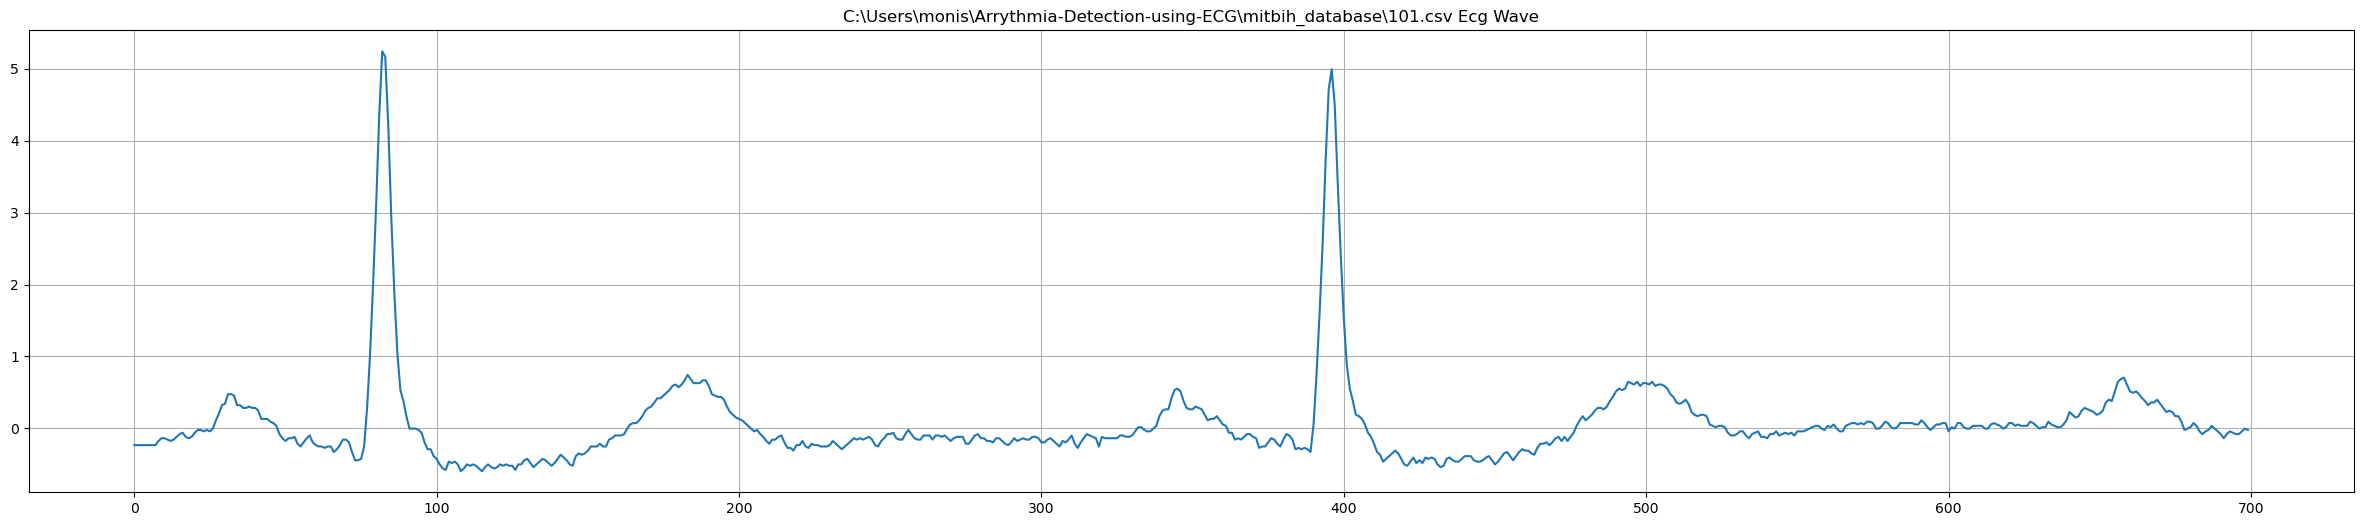

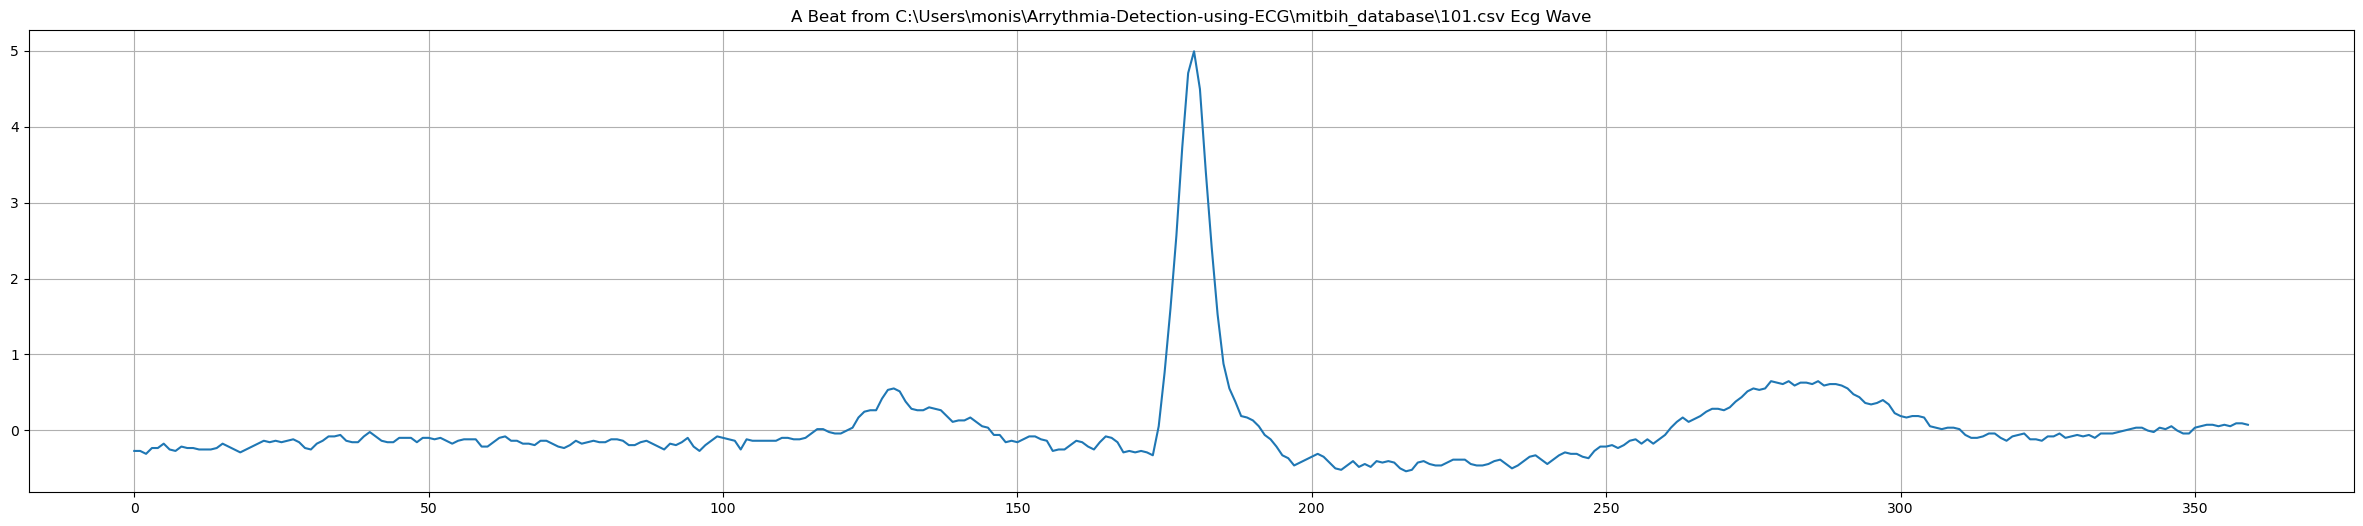

In [7]:
window_size = 180
for r in range(0, len(signaldata)):
    signals = []

    with open(signaldata[r], 'rt',) as csvfile:
        tempstorage = csv.reader(csvfile, delimiter=',',
                                 quotechar='|')
        insrtindx = -1
        for row in tempstorage:
            if(insrtindx >= 0):
                signals.insert(insrtindx, int(row[1]))
            insrtindx = insrtindx+1

    signals = stats.zscore(signals)

    if r == 1:
        plt_1 = plt.figure(figsize=(30, 6))
        plt.grid()

        plt.title(signaldata[1] + " Ecg Wave")

        plt.plot(signals[0:700])
        plt.show()
        sc=signals

    boolvar = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines()
        beat = list()

        for d in range(1, len(data)):
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted)
            pos = int(next(splitted))
            class_type = next(splitted)
            if(class_type in classnames):
                c_ind = classnames.index(class_type)

                count_classes[c_ind] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]
                    if r == 1 and not boolvar:
                        plt_1 = plt.figure(figsize=(30, 6))
                        plt.grid()
                        plt.title("A Beat from " + signaldata[1] + " Ecg Wave")
                        plt.plot(beat)
                        plt.show()
                        boolvar = True

                    X.append(beat)
                    y.append(c_ind)


In [8]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])

print(np.shape(X))


(95053, 361)


360
0.0    72312
2.0     7255
4.0     6870
1.0     6070
3.0     2546
Name: count, dtype: int64


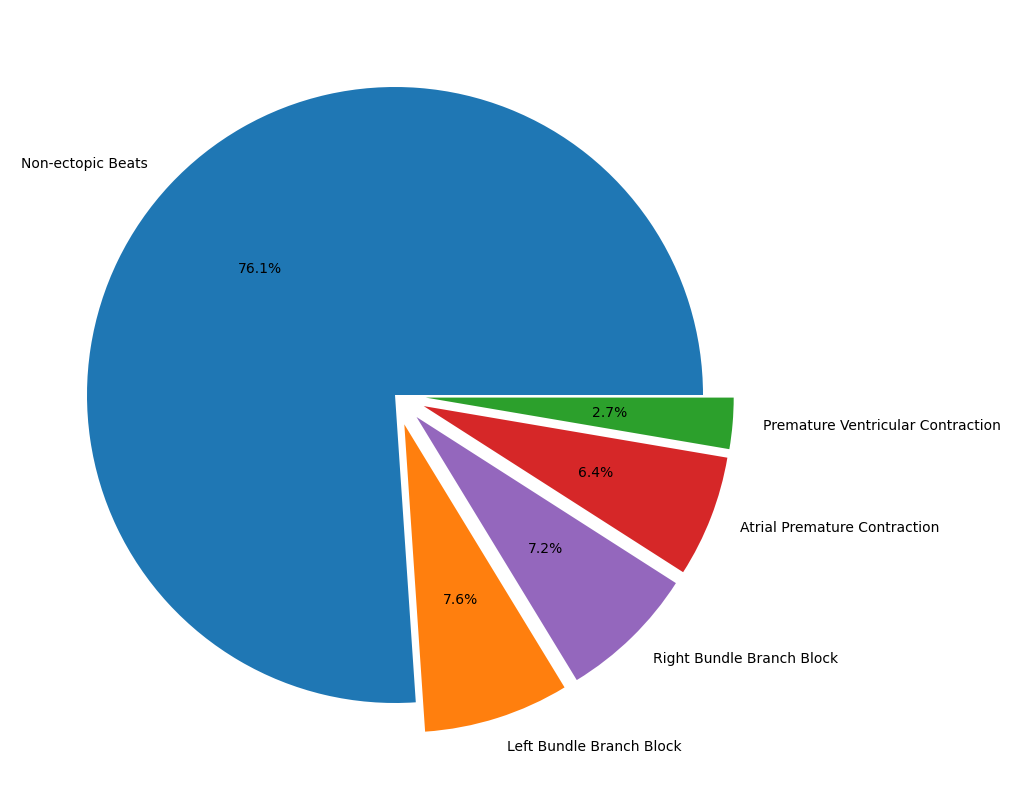

In [9]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
explode=(0,0.1,0.1,0.1,0.1)
plt.pie(per_class, labels=['Non-ectopic Beats', 'Left Bundle Branch Block', 'Right Bundle Branch Block', 'Atrial Premature Contraction', 'Premature Ventricular Contraction'],explode=explode, colors=['tab:blue','tab:orange','tab:purple','tab:red','tab:green'],autopct='%1.1f%%')
plt.show()

0    72312
3    72312
4    72312
1    72312
2    72312
Name: count, dtype: int64


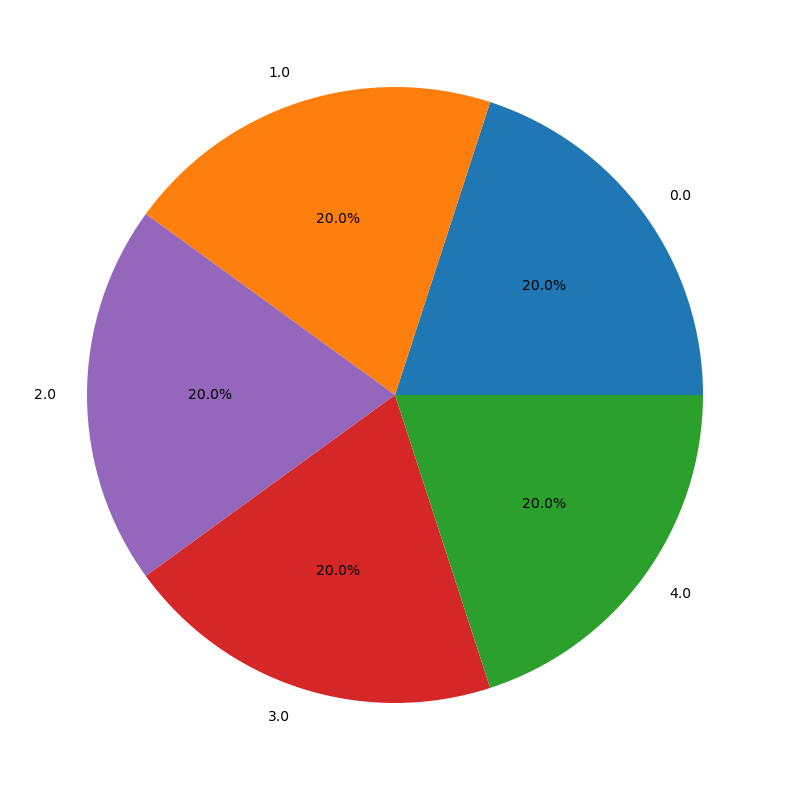

In [15]:
X = X_train_df.iloc[:, :-1]
y = X_train_df.iloc[:, -1]

le = LabelEncoder()
y = le.fit_transform(y)

smote = SMOTE()
X_sm, y_sm = smote.fit_resample(X, y)

class_dist = pd.Series(y_sm).value_counts()
print(class_dist)
plt.figure(figsize=(20,10))

plt.pie(class_dist, labels=le.classes_, colors=['tab:blue','tab:orange','tab:purple','tab:red','tab:green'],autopct='%1.1f%%')

plt.show()

In [16]:
train, test = train_test_split(X_train_df, test_size=0.20,random_state=45637)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (76042, 361)
X_test  :  (19011, 361)


In [17]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(76042, 5) (19011, 5)


In [18]:
train_y

array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [19]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

(76042, 360, 1) (19011, 360, 1)


In [20]:
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=13, padding='same', activation='relu',input_shape=(360, 1)))
model.add(AvgPool1D(pool_size=3, strides=2))
model.add(Conv1D(filters=64, kernel_size=17, padding='same', activation='relu'))
model.add(AvgPool1D(pool_size=3, strides=2))
model.add(Conv1D(filters=128, kernel_size=19, padding='same', activation='relu'))
model.add(AvgPool1D(pool_size=3, strides=2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(35,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
model.add(Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
model.add(Softmax())
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 360, 16)           224       
                                                                 
 average_pooling1d (Average  (None, 179, 16)           0         
 Pooling1D)                                                      
                                                                 
 conv1d_1 (Conv1D)           (None, 179, 64)           17472     
                                                                 
 average_pooling1d_1 (Avera  (None, 89, 64)            0         
 gePooling1D)                                                    
                                                                 
 conv1d_2 (Conv1D)           (None, 89, 128)           155776    
                                                                 
 average_pooling1d_2 (Avera  (None, 44, 128)          

In [21]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [23]:
modelbase = model.fit(train_x, train_y, batch_size=36, epochs=10, verbose=1, validation_data=(test_x, test_y))

Epoch 1/10
2113/2113 [==============================] - 75s 35ms/step - loss: 0.0284 - accuracy: 0.9946 - val_loss: 0.0314 - val_accuracy: 0.9953
Epoch 2/10
2113/2113 [==============================] - 77s 36ms/step - loss: 0.0263 - accuracy: 0.9952 - val_loss: 0.0335 - val_accuracy: 0.9942
Epoch 3/10
2113/2113 [==============================] - 64s 30ms/step - loss: 0.0238 - accuracy: 0.9958 - val_loss: 0.0339 - val_accuracy: 0.9946
Epoch 4/10
2113/2113 [==============================] - 71s 34ms/step - loss: 0.0281 - accuracy: 0.9950 - val_loss: 0.0320 - val_accuracy: 0.9951
Epoch 5/10
2113/2113 [==============================] - 76s 36ms/step - loss: 0.0237 - accuracy: 0.9957 - val_loss: 0.0324 - val_accuracy: 0.9943
Epoch 6/10
2113/2113 [==============================] - 76s 36ms/step - loss: 0.0210 - accuracy: 0.9962 - val_loss: 0.0328 - val_accuracy: 0.9951
Epoch 7/10
2113/2113 [==============================] - 79s 37ms/step - loss: 0.0214 - accuracy: 0.9962 - val_loss: 0.0338 -

In [24]:
model.save("modelecg.h5")
print("Saved model to disk")

Saved model to disk


c:\Users\monis\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


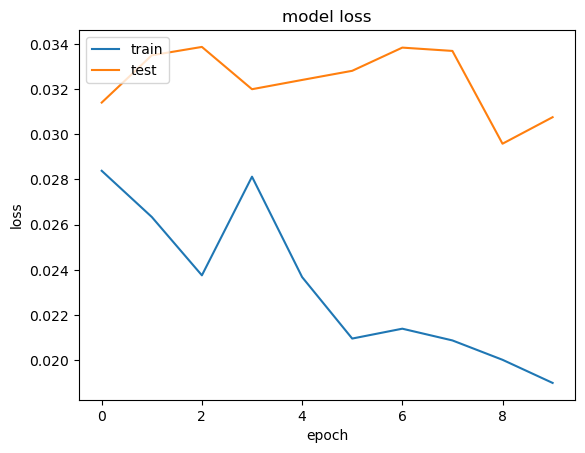

In [25]:
plt.plot(modelbase.history['loss'])
plt.plot(modelbase.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

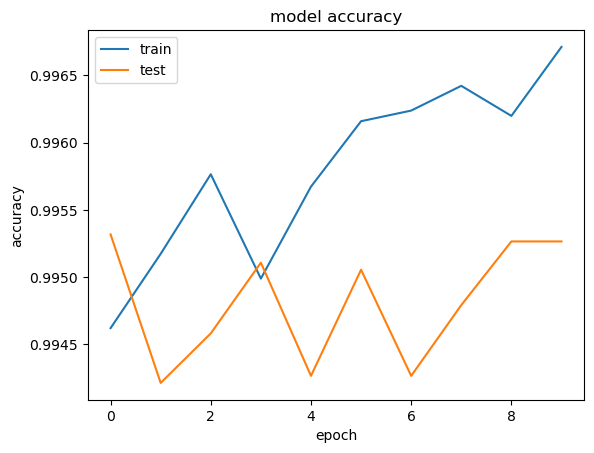

In [26]:
plt.plot(modelbase.history['accuracy'])
plt.plot(modelbase.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
score = model.evaluate(test_x, test_y)
y_pred=model.predict(test_x)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

595/595 [==============================] - 5s 9ms/step
Test Loss: 0.03075568936765194
Test accuracy: 0.9952659010887146


Normalized confusion matrix


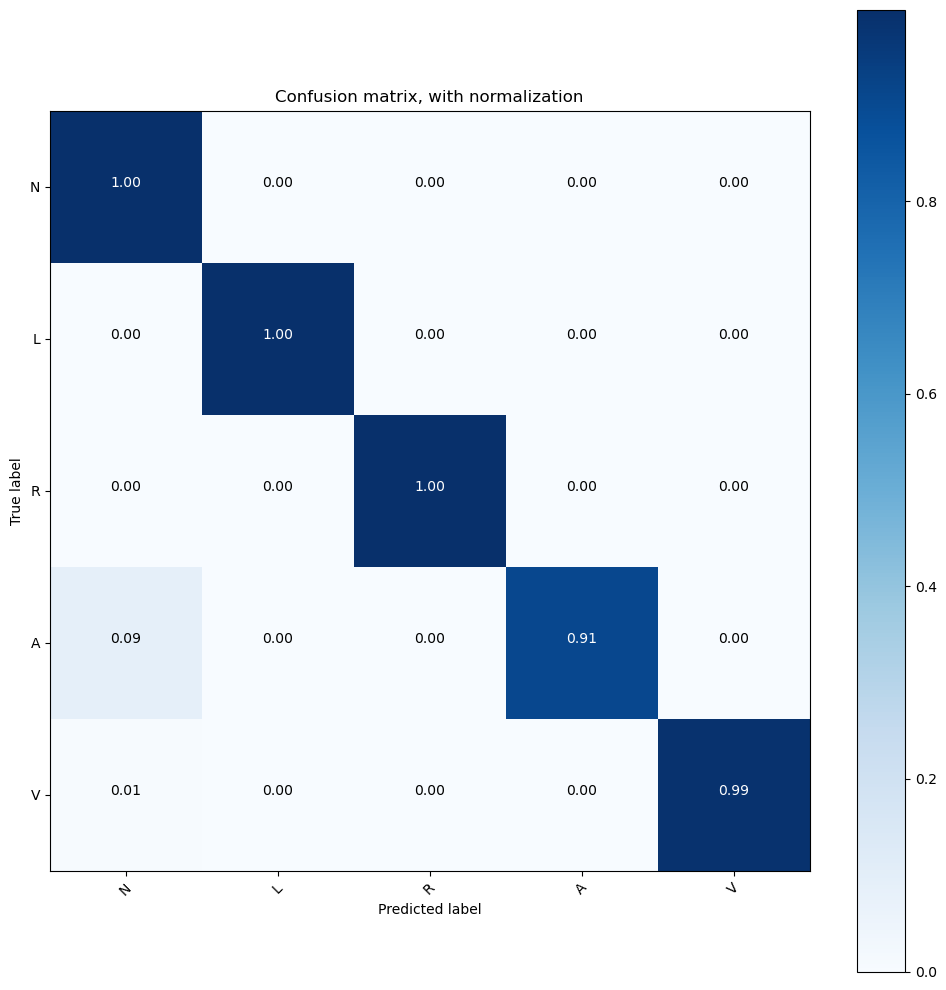

In [28]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from sklearn.utils import class_weight
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(test_y.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'L', 'R', 'A', 'V'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()

In [29]:

from sklearn.model_selection import StratifiedKFold
import numpy as np
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cvscores = []
for i in range(0,5):
	randomnum=np.random.randint(1,6456476)
	train, test = train_test_split(X_train_df, test_size=0.20,random_state=randomnum)

	

	target_train=train[train.shape[1]-1]
	target_test=test[test.shape[1]-1]
	train_y=to_categorical(target_train)
	test_y=to_categorical(target_test)

	train_x = train.iloc[:,:train.shape[1]-1].values
	test_x = test.iloc[:,:test.shape[1]-1].values
	train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
	test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
	print(np.shape(train_x), np.shape(test_x))
	model = Sequential()
	model.add(Conv1D(filters=16, kernel_size=13, padding='same', activation='relu',input_shape=(360, 1)))
	model.add(AvgPool1D(pool_size=3, strides=2))
	model.add(Conv1D(filters=64, kernel_size=17, padding='same', activation='relu'))
	model.add(AvgPool1D(pool_size=3, strides=2))
	model.add(Conv1D(filters=128, kernel_size=19, padding='same', activation='relu'))
	model.add(AvgPool1D(pool_size=3, strides=2))
	model.add(Flatten())
	model.add(Dropout(0.5))
	model.add(Dense(35,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
	model.add(Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
	model.add(Softmax())
# model.summary()
	model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])	# Fit the model
	model.fit(train_x, train_y, epochs=10, batch_size=36, verbose=1)
	scores = model.evaluate(test_x, test_y, verbose=1)
	print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
	cvscores.append(scores[1] * 100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

(76042, 360, 1) (19011, 360, 1)
Epoch 1/10
2113/2113 [==============================] - 75s 35ms/step - loss: 0.1193 - accuracy: 0.9723
Epoch 2/10
2113/2113 [==============================] - 87s 41ms/step - loss: 0.0620 - accuracy: 0.9877
Epoch 3/10
2113/2113 [==============================] - 88s 42ms/step - loss: 0.0516 - accuracy: 0.9906
Epoch 4/10
2113/2113 [==============================] - 73s 34ms/step - loss: 0.0465 - accuracy: 0.9915
Epoch 5/10
2113/2113 [==============================] - 71s 34ms/step - loss: 0.0426 - accuracy: 0.9924
Epoch 6/10
2113/2113 [==============================] - 75s 35ms/step - loss: 0.0386 - accuracy: 0.9929
Epoch 7/10
2113/2113 [==============================] - 100s 47ms/step - loss: 0.0338 - accuracy: 0.9936
Epoch 8/10
2113/2113 [==============================] - 80s 38ms/step - loss: 0.0333 - accuracy: 0.9939
Epoch 9/10
2113/2113 [==============================] - 73s 34ms/step - loss: 0.0302 - accuracy: 0.9946
Epoch 10/10
595/595 [==========